In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\ASUS\Downloads\Fraud.csv")

In [3]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

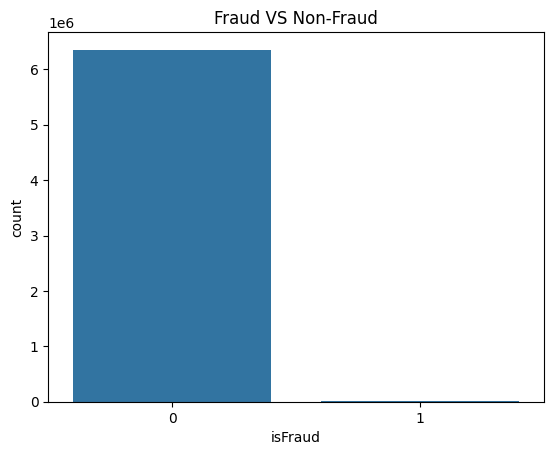

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [7]:
sns.countplot(data=df , x = 'isFraud')
plt.title("Fraud VS Non-Fraud")
plt.show()
df['isFraud'].value_counts(normalize=True)

In [8]:
df[df['isFraud'] == 1].shape[0]

8213

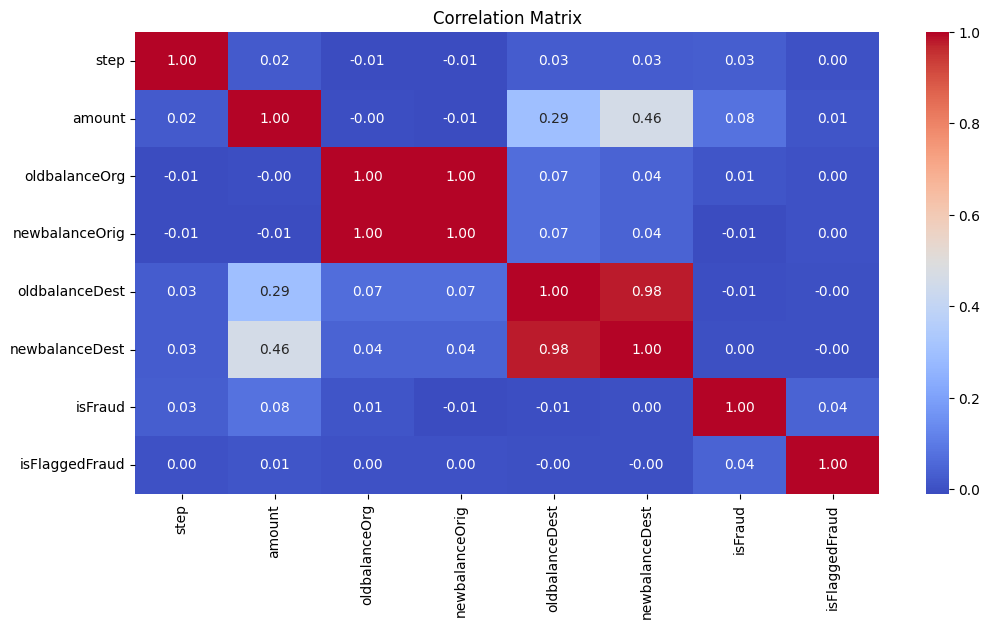

In [9]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12,6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [10]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['amount'] < lower) | (df['amount'] > upper)]
print(f"Number of outliers: {outliers.shape[0]}")



Number of outliers: 338078


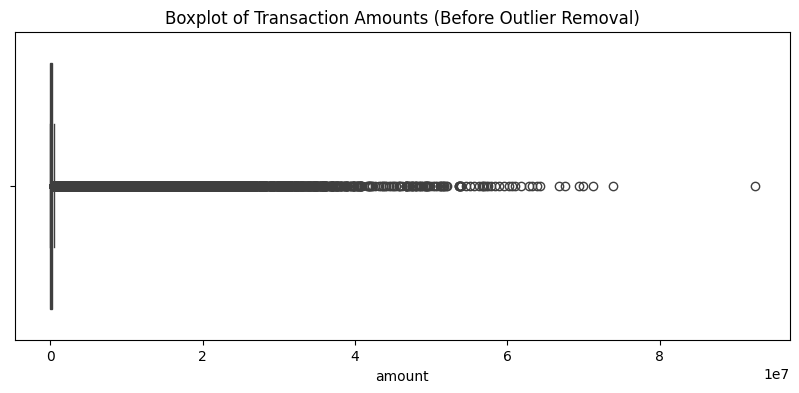

In [11]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['amount'])
plt.title("Boxplot of Transaction Amounts (Before Outlier Removal)")
plt.show()

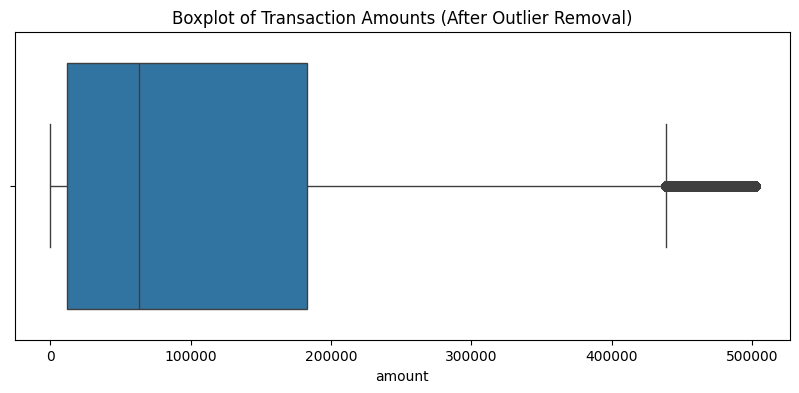

In [12]:
df = df[(df['amount'] >= lower) & (df['amount'] <= upper)]
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['amount'])
plt.title("Boxplot of Transaction Amounts (After Outlier Removal)")
plt.show()

In [13]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

x_1 = df.drop('isFraud', axis=1)._get_numeric_data()
x_1 = add_constant(x_1)

vif_data = pd.DataFrame()
vif_data["feature"] = x_1.columns
vif_data["VIF Factor"] = [variance_inflation_factor(x_1.values, i)
                          for i in range(x_1.shape[1])]

vif_data


,feature,VIF Factor
0,const,4.908545
1,step,1.004715
2,amount,1.383026
3,oldbalanceOrg,1476.105150
4,newbalanceOrig,1489.371174
5,oldbalanceDest,209.276176
6,newbalanceDest,210.482203
7,isFlaggedFraud,1.000006


In [14]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report
#if type in df.columns:
   # df = pd.get_dummies(df, columns=['type'], drop_first=True) #using one hot encoding cause RandomForestClassifer uses only numeric data type 

rf = RandomForestClassifier()
X = df.drop(['isFraud','nameDest','nameOrig'], axis =1)
y = df['isFraud']



In [16]:
df_sample,_  = train_test_split(df, test_size=0.99, stratify=df['isFraud'], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=50,max_depth=10, n_jobs=-1, random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("Accuracy:",accuracy_score(y_test,y_pred))
print("Classification Report:",classification_report(y_test,y_pred))

Accuracy: 0.9996519791541599
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1806062
           1       0.99      0.52      0.68      1301

    accuracy                           1.00   1807363
   macro avg       0.99      0.76      0.84   1807363
weighted avg       1.00      1.00      1.00   1807363



In [17]:
print(df.columns)

Index(['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')


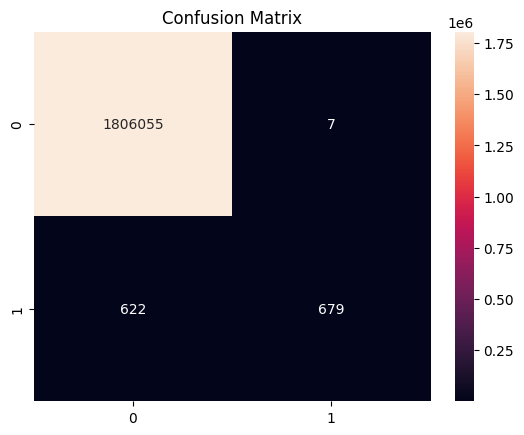

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm , annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.show()

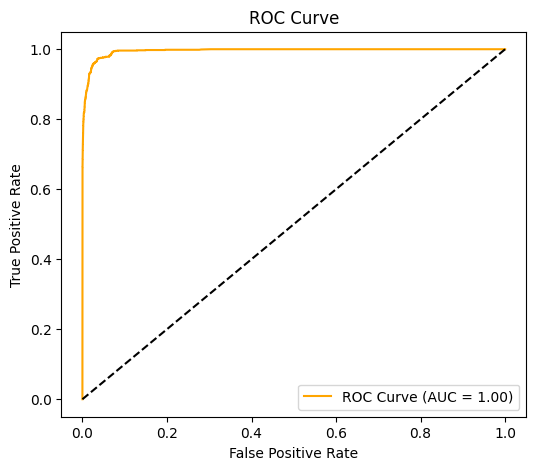

In [20]:
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import roc_auc_score
y_prob = model.predict_proba(X_test)[:,1] #probability for class 1 (fraud)
fpr,tpr,threshould = roc_curve(y_test,y_prob)
roc_aur = auc (fpr,tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr,tpr,color = 'orange',label = 'ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0,1],[0,1],'k--')  #draws a line from (0,0) to (1,1) [black colour line '-']
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
#Buisness insights & Recommendtions

1.) What are the key factors that predict fraudulent transactions?
sol) The main key factors that predict fraudulent transactions are:
    -> Amount : larget amount transactions are more likely to be fraudulent
    -> oldbalanceorig : High original balance could signal in suspecious activity , when followed by an large transaction
    -> newbalanceorig : balance sudden drop to zero can lead to patterns of fraud
    -> Type : Transation type  is also an key factor relating to fraud , such as cash withdrawal or money transfer to unknown accounts

2.) Do these factors make logical sense?
sol) Yes these factors make logical sense , as they are all related to the amount of money being transacted and the type of transaction being made. Most frauds occur via "TRANSFER" and "CASH OUT" 
    which are direct money out methods. Also, frauds are more likely to occur when the original balance is high and then suddenly drops to zero .
    Fraudulent transactions often involve unusually high amounts.

3.) What kind of prevention should be adopted while the company updates its infrastructure?
sol) The company should adopt the following prevention methods:
    -> Implementing a more robust fraud detection system that can identify and flag suspicious transactions in real-TimeoutError    
    -> Trigger alerts when transaction exceeds normal limits of that accounts 
    -> Adapt daily transaction limits 
    -> Monitering the transaction flow and keeping track of any abnormal transactions 

4.) How would you determine if those improvements are effective?
sol) To determine if those improvements are effective, the company should track and analyze the following metrics:
    -> Number of fraudulent transactions detected and prevented
    -> Customer support
    -> feedback from the customers 
